# Contexto

Este notebook presenta el entrenamiento de diferentes algoritmos de reconocimiento de patrones para maximizar el score de estabilidad de prediccion de mora en créditos hipotecarios del challenge de Kaggle "Home Credit - Credit Risk Model Stability". Disponible en:

https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability



## Librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import time
from sklearn.ensemble import VotingClassifier

## Lectura de datos

In [2]:
# Leer información de datos preprocesados
df_train = pd.read_pickle('Data/processed/df_train.pkl')
df_test = pd.read_pickle('Data/processed/df_test.pkl')

## Preparación de datos

In [3]:
# Revisamos distribucioón de la variable objetivo
df_train['target'].value_counts(normalize=True)

target
0    0.968563
1    0.031437
Name: proportion, dtype: float64

Debido al desbalanceo del target es alto todos los modelos se realizan con la parametrización 

In [4]:
# Quitar variables de target, case_id
X = df_train.drop(columns=['target', 'case_id'])
y = df_train['target']

# Se generan los splits para generar el conjunto de teteo
X_train, X_test, y_train, y_test = train_test_split(X
                                                    ,y
                                                    ,test_size=0.15
                                                    ,random_state=951
                                                    )

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train.shape

# Se define weeks para estratificación
weeks = X_train['WEEK_NUM']

# Se elimina week_num de ambos conjutos
X_train = X_train.drop(columns=['WEEK_NUM'])
X_test = X_test.drop(columns=['WEEK_NUM'])

# Se define la division por 5 splits estratificadas
cv = StratifiedGroupKFold(n_splits=5
                          , shuffle=True
                          , random_state=846
                         )

In [5]:
y_train.value_counts(normalize=True)

target
0    0.5
1    0.5
Name: proportion, dtype: float64

## Entrenamiento

Se genera la función de evaluacion de modelo frente al conjunto de test:

In [6]:
def evaluate_model(model, model_name, X_test, params, y_test=np.array([0]), device = 'cuda'):
    if model_name == 'ann':
        y_test, y_pred = evaluate_nn(model, X_test, device)
        y_test = [1 if p[0] > 0 else 0 for p in y_test]
        y_pred = [1 if p[0] > 0.1 else 0 for p in y_pred]
    else:
        y_pred = model.predict(X_test)
    return {
        'modelo': model_name
        ,'parametros': str(params)
        ,'accuracy_score': accuracy_score(y_test, y_pred)
        ,'precision_score': precision_score(y_test, y_pred)
        ,'recall_score': recall_score(y_test, y_pred)
        ,'f1_score': f1_score(y_test, y_pred)
        ,'roc_auc_score': roc_auc_score(y_test, y_pred)
    }

### Logit

In [7]:
log_model = joblib.load('Modelos/Modelos_Principales/best_logit.joblib')

### Random Forest

In [8]:
rf_model = joblib.load('Modelos/Modelos_Principales/best_random_forest.joblib')

### Naive Bayes

In [9]:
nb_model = joblib.load('Modelos/Modelos_Principales/best_naive_bayes.joblib')

### ANN

In [10]:
torch.manual_seed(42)
# Verificar device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convertir a tensores
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=951)
X_train_tensor = torch.tensor(np.array(X_train_train), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(np.array(y_train_train.values), dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(np.array(X_val), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(np.array(y_val.values), dtype=torch.float32).unsqueeze(1).to(device)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=512, shuffle=False)

Using device: cuda


In [11]:
# Se define la arquitectura de la red
class RedInicial(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(RedInicial, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # Primera capa oculta
        self.relu1 = nn.ReLU()  # Activación ReLU
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # Segunda capa oculta
        self.relu2 = nn.ReLU()  # Activación ReLU
        self.fc3 = nn.Linear(hidden_dim2, output_dim)  # Capa de salida
        self.sigmoid = nn.Sigmoid()  # Activación Sigmoid

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [12]:
# Se define una funcion de entrenamiento que ajuste de forma dinecta los hiperparametros
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Mover los datos a la GPU
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Mover los datos a la GPU
                outputs = model(X_batch)
                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())
        
        val_roc_auc = roc_auc_score(y_true, y_pred)
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation ROC AUC: {val_roc_auc:.4f}, Time: {epoch_time:.2f}s")

# Se define una funicon para comparar valores reales con predichos
def evaluate_nn(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Mover los datos a la GPU
            outputs = model(X_batch)
            y_true.extend(y_batch.tolist())
            y_pred.extend(outputs.tolist())
    return y_true, y_pred

In [13]:
resultados_ann = pd.read_parquet('Modelos/RS_Neural_Network.parquet')
resultados_ann = resultados_ann.sort_values(by='val_roc_auc', ascending = False).reset_index(drop = True)
resultados_ann['dummy'] = 1
resultados_ann['rank_test_score'] = resultados_ann.groupby('dummy').cumcount() + 1
resultados_ann.drop(columns=['dummy'], inplace = True)
mejor_resultado = resultados_ann[resultados_ann['rank_test_score']==1]

In [14]:
# Cargar el modelo más tarde
ann_model = RedInicial(input_dim=X_train_tensor.shape[1]
                       , hidden_dim1=mejor_resultado.hidden_dim1.values[0]
                       , hidden_dim2=mejor_resultado.hidden_dim2.values[0]
                       , output_dim=1
                      ).to(device)
ann_model.load_state_dict(torch.load('Modelos/Modelos_Principales/best_neural_network.pth'
                                     , map_location=device
                                     )
                          )

# Evaluar el modelo cargado en el conjunto de prueba

X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(np.array(y_test.values), dtype=torch.float32).unsqueeze(1).to(device)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)




## Rendimiento de cada modelo

In [15]:
#Crear dataframe donde se alojan resultados sobre el conjunto de test

metricas_df = pd.DataFrame(columns = ['modelo'
                                      ,'parametros'
                                      ,'accuracy_score'
                                      ,'precision_score'
                                      ,'recall_score'
                                      ,'f1_score'
                                      ,'roc_auc_score'
                                     ]
                          )

for i in ['log_model'
         ,'rf_model'
         ,'nb_model'
         ,'ann_model']:

    if i != 'ann_model':
        exec(f"raw_value = evaluate_model(model = {i},model_name = '{i}'[:3], X_test = X_test, y_test = y_test, params = {i}.get_params)")
    else:
        exec(f"raw_value = evaluate_model(model = {i},model_name = '{i}'[:3], X_test = test_loader, params = mejor_resultado.to_dict())")
    metricas_df = pd.concat([metricas_df, pd.DataFrame([raw_value])])
metricas_df

,modelo,parametros,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,log,<bound method BaseEstimator.get_params of Logi...,0.679073,0.059789,0.628348,0.109188,0.654530
0,rf_,<bound method BaseEstimator.get_params of Rand...,0.963799,0.050481,0.008789,0.014971,0.501724
0,nb_,<bound method BaseEstimator.get_params of Gaus...,0.454277,0.040518,0.724609,0.076745,0.585076
0,ann,"{'hidden_dim1': {0: 119}, 'hidden_dim2': {0: 3...",0.799130,0.062389,0.386161,0.107422,0.599318


## Modelo Ensemble

In [16]:
ensemble_model = VotingClassifier(estimators=[('log', log_model)
                                              ,('rf', rf_model)
                                              ,('nb', nb_model)
                                             ]
                                  , voting='hard'
                                  , verbose = True
                                 ) 

# Entrenar el modelo ensamblado
ensemble_model.fit(X_train, y_train)

# Guardar Modelo
joblib.dump(ensemble_model, 'Modelos/Modelos_Principales/ensemble.joblib')

[Voting] ...................... (1 of 3) Processing log, total=  31.1s
[Voting] ....................... (2 of 3) Processing rf, total= 1.0min
[Voting] ....................... (3 of 3) Processing nb, total=   2.7s


['Modelos/Modelos_Principales/ensemble.joblib']

In [17]:
for i in ['ensemble_model']:

    if i != 'ann_model':
        exec(f"raw_value = evaluate_model(model = {i},model_name = '{i}'[:3], X_test = X_test, y_test = y_test, params = {i}.get_params)")
    else:
        exec(f"raw_value = evaluate_model(model = {i},model_name = '{i}'[:3], X_test = test_loader, params = mejor_resultado.to_dict())")
    metricas_df = pd.concat([metricas_df, pd.DataFrame([raw_value])])

In [18]:
metricas_df.to_parquet('Modelos/Resultados_Mejores_Modelos.parquet')

## PCA

In [19]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

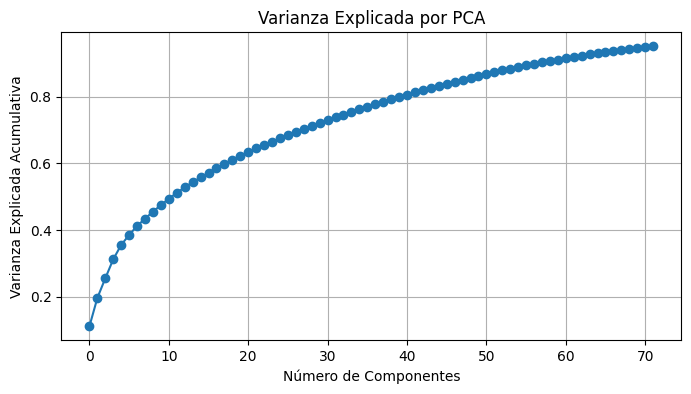

In [20]:
pca = PCA(n_components=0.95) # Conservar el 95% de la varianza
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

pca_columns = ['PC' + str(i+1) for i in range(X_train_pca.shape[1])]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)

# Varianza explicada
varianza_explicada = pca.explained_variance_ratio_.cumsum()

# Graficar la varianza explicada acumulativa
plt.figure(figsize=(8, 4))
plt.plot(varianza_explicada, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulativa')
plt.title('Varianza Explicada por PCA')
plt.grid(True)
plt.show()

In [21]:
X_train_pca_df = X_train_pca_df.iloc[:, :10]
X_test_pca_df = X_test_pca_df.iloc[:, :10]

In [22]:
X_train_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.661701,1.165067,1.134399,-0.161325,-0.189739,-0.955907,0.106658,-0.397884,-0.146514,-0.293272
1,0.902399,1.540789,-0.668735,-0.597765,-0.116072,1.337460,-1.197787,-0.088198,-0.229639,-0.508672
2,-0.079606,2.038252,-0.564666,-0.140380,-0.384467,0.885591,-0.557870,-0.046659,-0.221876,-0.380380
3,0.170257,-0.968258,-0.911222,0.675619,0.061949,-0.735584,-1.194989,0.322549,-0.681477,0.898946
4,-0.983060,-1.388018,1.247099,0.497953,0.324761,0.135387,-0.720649,0.419040,1.075864,-0.592218


In [23]:
# Definir el espacio de búsqueda de hiperparámetros
nb_param_dist = {
    'var_smoothing': np.logspace(0, -9, num=100)  # Explorando valores en una escala logarítmica
}

# Configurar el RandomizedSearchCV
nb_random_search = RandomizedSearchCV(
    estimator=GaussianNB(),
    param_distributions=nb_param_dist,
    n_iter=25,
    cv=cv,
    verbose=4,
    random_state=42,
    n_jobs=2,
    scoring='roc_auc',
    return_train_score=True
)

# Entrenar el modelo usando el RandomizedSearchCV
nb_random_search.fit(X_train_pca_df, y_train, groups=weeks)

# Guardar Resultados
cv_results_nb = pd.DataFrame(nb_random_search.cv_results_)
cv_results_nb.to_parquet('Modelos/RS_Naive_Bayes_PCA.parquet')

# Guardar Mejor Modelo
joblib.dump(nb_random_search.best_estimator_, 'Modelos/Modelos_Principales/best_naive_bayes_PCA.joblib')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


['Modelos/Modelos_Principales/best_naive_bayes_PCA.joblib']

In [24]:
evaluate_model(model = nb_random_search.best_estimator_,model_name = 'nb_pca', X_test = X_test_pca_df, y_test = y_test, params = nb_random_search.best_params_)

{'modelo': 'nb_pca',
 'parametros': "{'var_smoothing': 6.579332246575682e-09}",
 'accuracy_score': 0.645911117515797,
 'precision_score': 0.04854274057606332,
 'recall_score': 0.5544084821428571,
 'f1_score': 0.08926926792012041,
 'roc_auc_score': 0.6016381569803864}

In [26]:
%%time
# Se genera un diccionario de parametros por cada modelo a probar
rf_param_dist = {
    'n_estimators': [10, 50, 100, 200]
    ,'max_features': ['sqrt', 'log2']
    ,'max_depth': [10, 20, 30]
    ,'min_samples_split': [2, 5, 10]
    ,'min_samples_leaf': [1, 2, 4]
    ,'bootstrap': [True, False]
}

# Se genera un random search para cada modelo
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1
                                    )
    ,param_distributions=rf_param_dist
    ,n_iter=12
    ,cv=cv
    ,verbose=4
    ,random_state=42
    ,n_jobs=1
    ,scoring = 'roc_auc'
    ,return_train_score = True
)

rf_random_search.fit(X_train_pca_df, y_train, groups=weeks)

# Guardar Resultados

cv_results = pd.DataFrame(rf_random_search.cv_results_)
cv_results.to_parquet('Modelos/RS_Random_Forest_PCA.parquet')

# Guardar Mejor Modelo

joblib.dump(rf_random_search.best_estimator_, 'Modelos/Modelos_Principales/best_random_forest_PCA.joblib')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10;, score=(train=0.999, test=0.780) total time=  20.7s
[CV 2/5] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10;, score=(train=0.999, test=0.790) total time=  19.8s
[CV 3/5] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10;, score=(train=0.999, test=0.820) total time=  19.8s
[CV 4/5] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10;, score=(train=0.999, test=0.790) total time=  20.6s
[CV 5/5] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10;, score=(train=0.999, test=0.792) total time=  19.7s
[CV 1/5] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_

['Modelos/Modelos_Principales/best_random_forest_PCA.joblib']

In [27]:
evaluate_model(model = rf_random_search.best_estimator_,model_name = 'rf_pca', X_test = X_test_pca_df, y_test = y_test, params = rf_random_search.best_params_)

{'modelo': 'rf_pca',
 'parametros': "{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}",
 'accuracy_score': 0.8739121131533325,
 'precision_score': 0.0626611863313991,
 'recall_score': 0.21693638392857142,
 'f1_score': 0.09723611805902951,
 'roc_auc_score': 0.5560386397375906}

In [28]:
%%time
# Se genera un diccionario de parametros por cada modelo a probar

logistic_param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10]
    ,'penalty': ['l1']
    ,'solver': ['saga']
}

# Se genera un grid search para cada modelo


logistic_random_search = RandomizedSearchCV(
    estimator=LogisticRegression(n_jobs=-1
                                ,max_iter=10
                                )
    ,param_distributions=logistic_param_dist
    ,n_iter=25
    ,cv=cv
    ,verbose=4
    ,random_state=42
    ,n_jobs=1
    ,scoring = 'roc_auc'
    ,return_train_score = True
)

logistic_random_search.fit(X_train_pca_df, y_train, groups=weeks)

# Guardar Resultados

cv_results = pd.DataFrame(logistic_random_search.cv_results_)
cv_results.to_parquet('Modelos/RS_Logit_PCA.parquet')

# Guardar Mejor Modelo

joblib.dump(logistic_random_search.best_estimator_, 'Modelos/Modelos_Principales/best_logit_PCA.joblib')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.653, test=0.658) total time=   6.1s
[CV 2/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.655, test=0.650) total time=   6.1s
[CV 3/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.654, test=0.652) total time=   6.1s
[CV 4/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.653, test=0.657) total time=   6.3s
[CV 5/5] END C=0.001, penalty=l1, solver=saga;, score=(train=0.655, test=0.648) total time=   6.3s
[CV 1/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.653, test=0.658) total time=   6.0s
[CV 2/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.655, test=0.650) total time=   6.1s
[CV 3/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.654, test=0.652) total time=   6.1s
[CV 4/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.653, test=0.657) total time=   6.4s
[CV 5/5] END C=0.01, penalty=l1, solver=saga;, score=

['Modelos/Modelos_Principales/best_logit_PCA.joblib']

In [29]:
evaluate_model(model = logistic_random_search.best_estimator_,model_name = 'log_pca', X_test = X_test_pca_df, y_test = y_test, params = logistic_random_search.best_params_)

{'modelo': 'log_pca',
 'parametros': "{'solver': 'saga', 'penalty': 'l1', 'C': 0.001}",
 'accuracy_score': 0.6505050240394062,
 'precision_score': 0.050287604611548624,
 'recall_score': 0.568359375,
 'f1_score': 0.0923998094849289,
 'roc_auc_score': 0.6107593810504957}

In [30]:
# Convertir a tensores
X_train_train_pca, X_val, y_train_train_pca, y_val = train_test_split(X_train_pca, y_train, test_size=0.15, random_state=951)
X_train_tensor = torch.tensor(np.array(X_train_train_pca), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(np.array(y_train_train.values), dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(np.array(X_val_pca), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(np.array(y_val.values), dtype=torch.float32).unsqueeze(1).to(device)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor_pca, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor_pca, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=512, shuffle=False)

NameError: name 'X_val_pca' is not defined

In [ ]:
%%time
random.seed(1234)
# Definir el espacio de hiperparámetros
param_dist = {
    'hidden_dim1': [32, 64, 119]
    ,'hidden_dim2': [32, 64]
    ,'learning_rate': [0.01, 0.001, 0.0001]
    ,'num_epochs': [30, 50, 70]
}

# Lista para almacenar los resultados de cada modelo
search_results = []

# Realizar Random Search
num_searches = 5
best_model = None
best_roc_auc = 0.0

for _ in range(num_searches):
    start_time = time.time()
    hidden_dim1 = random.choice(param_dist['hidden_dim1'])
    hidden_dim2 = random.choice(param_dist['hidden_dim2'])
    learning_rate = random.choice(param_dist['learning_rate'])
    num_epochs = random.choice(param_dist['num_epochs'])
    
    model = RedInicial(input_dim=X_train_pca_df.shape[1], hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=1).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    end_time = time.time()
    search_time = end_time - start_time
        
    print(f"Training with hidden_dim1={hidden_dim1}, hidden_dim2={hidden_dim2}, learning_rate={learning_rate}, num_epochs={num_epochs}")
    train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)
    print(f'Time of search point: {search_time}')
    
    y_true, y_pred = evaluate_nn(model, val_loader, device)
    val_roc_auc = roc_auc_score(y_true, y_pred)
    
    # Guardar los resultados del modelo actual
    result = {
        'hidden_dim1': hidden_dim1,
        'hidden_dim2': hidden_dim2,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'val_roc_auc': val_roc_auc
    }
    search_results.append(result)
    
    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        best_model = model

print(f"Best model has validation ROC AUC: {best_roc_auc:.4f}")

# Convertir los resultados a un DataFrame
search_results_df = pd.DataFrame(search_results)

# Guardar los resultados en un archivo Parquet
search_results_df.to_parquet('Modelos/RS_Neural_Network_PCA.parquet')

# Guarar el mejor modelo
torch.save(best_model.state_dict(), 'Modelos/Modelos_Principales/best_neural_network_PCA.pth')